# ```Semantic segmentation using unet```


## Description

Semantic segmentation is a computer vision task in which we label specific regions according to which what it's being shown. Unlike Image classification where the output to an image is a single class label, the semantic segmentation desired output should include localization information, i.e., a class label supposed to be assigned to each pixel of the image. This task of labeling each pixel is commonly referred as dense prediction which is known as semantic segmentation.

## Overview

In this chapter, let us see how we can use convolutional neural networks for semantic segmentation. 


## Pre-requisite

1. pytorch knowledge 

## Learning Outcomes

1. Understing U-net network through "Carvana dataset"

## Chapter 1: ```Problem description```

### Description

The training and testing dataset is collected from the Carvana Image Masking challenge and it can be dowloaded from [here](https://www.kaggle.com/vfdev5/data-visualization/data). This two dataset contains a large number of car images (as .jpg files). Each car has exactly 16 images (with 16 different orientations), each one taken at different angles. Each car has a unique id and images are named according to id_01.jpg, id_02.jpg ... id_16.jpg. In addition to the images, we are also provided some basic metadata about the car make, model, year, and trim.

For the training set, we are provided a .gif file that contains the manually cutout mask for each image. The task is to automatically segment the cars in the images in the test set folder. In the following cells let us do data visualization of the training set. As in the problem, we are dealing with images, which actually means the 2 dimensional array of pixel intensities(say numbers), it is important to have the knowledge of [numpy](http://www.numpy.org/) library (it contains powerful N-dimensional array object) and [PIL] (https://pillow.readthedocs.io/en/stable/) (it is a python image library)

### Training data Visualisation

The following code block loads both train images and train mask gifs

In [44]:
import numpy as np
from matplotlib import pyplot as plt
import os  
from PIL import Image
from glob import glob
from skimage import segmentation

input_path = '../images/input'
train_data_path = os.path.join(input_path, 'train')
train_masks_path = os.path.join(input_path, 'train_masks')
train_files = glob(os.path.join(train_data_path, '*.jpg'))

Let us see one training image with it's corresponding mask

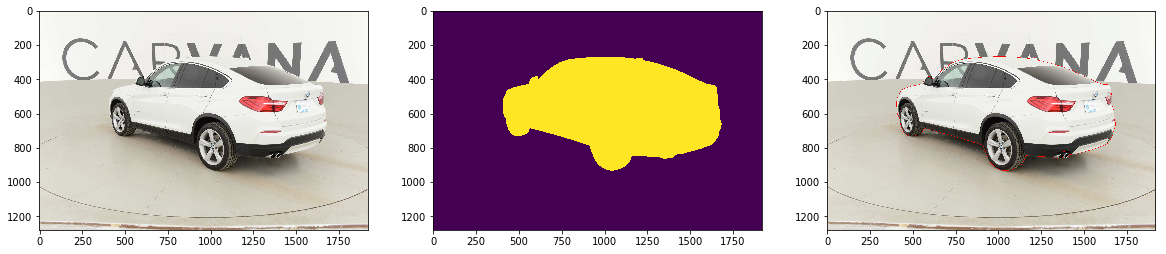

In [45]:
def get_mask_for_train_file(train_file, train_masks_path):
    train_id = os.path.basename(train_file)[:-len('.jpg')]
    train_mask_path = os.path.join(train_masks_path, train_id + '_mask.gif')
    return train_mask_path

train_file = train_files[0]
train_mask_file = get_mask_for_train_file(train_file, train_masks_path)

train_img_pil = Image.open(train_file)
train_mask_pil = Image.open(train_mask_file)
train_img = np.asarray(img_pil)
train_mask_img = np.asarray(train_mask_pil)
##get boundaries of the car
train_boundary_img = segmentation.mark_boundaries(train_img, train_mask_img, 
                                                  color=(1,0,0), mode='thick')

## plot the training image
plt.figure(figsize=(20,20))
plt.subplot(131)
plt.imshow(train_img)
plt.subplot(132)
plt.imshow(train_mask_img)
plt.subplot(133)
plt.imshow(train_boundary_img)

### Task: Semantic segmentation

The task here is simply to take the colored car image and output a mask of 2 colors of which one color corresponds to the background and other one corresponds to the car. It is simple as shown as below
<img src='../images/semantic_segmentation.png'>

There are many deep learning methods to do the above task. The following state of the art methods (current and previous) uses convolutional neural networks for image segmentation task.

1. Fully Convolutional networks for semantic segmentation - FCN ([2014](https://arxiv.org/abs/1411.4038))
2. SegNet ([2015](https://arxiv.org/abs/1511.00561))
3. U-Net ([2015](https://arxiv.org/abs/1505.04597))
4. Dilated Convolutions ([2015](https://arxiv.org/abs/1511.07122)) 
5. DeepLab v1 & v2 ([2014](https://arxiv.org/abs/1412.7062) & [2016](https://arxiv.org/abs/1606.00915))
6. RefineNet ([2016](https://arxiv.org/abs/1611.06612))
7. DeepLab v3 ([2017](https://arxiv.org/abs/1706.05587))

FCN is the first method to use convoluted layers fully for the dense predictions without any fully connected layers.  This allowed segmentation maps to be generated for image of any size and was also much faster compared to the patch classification approach. Almost all the subsequent state of the art approaches on semantic segmentation adopted this paradigm

Apart from fully connected layers, one of the main problems with using CNNs for segmentation is pooling layers. Pooling layers increase the field of view and are able to aggregate the context while discarding the ‘where’ information. However, semantic segmentation requires the exact alignment of class maps and thus, needs the ‘where’ information to be preserved. The following u-net model tackles this problem

## Chapter 2: ```Unet model```

### Description

U-net model is built upon a more elagant architecture called "fully-convolutional network" for image segmentation. The main idea in "fully-convolutional network" is to supplement a usual contracting network by adding successive layers, where the layers are constructed by replacing the pooling layers with up-sampling layers. Hence the additional layers increases the resolution of the output. In order to localize, the more resolution features of the contracting path are combined with the upsampled output. A successive convolutional layer can then learn to assemble a more precise output based on this information. 

One more important modification in the U-net architecture compared to the "fully-convolutional network" is that in the upsampling part also have a large number of feature channels, which allow the network to propogate the context information to the higher resolution layers. As a result, the expansive path is more or less symmetric to the contracting path, and yields a u-shaped architecute.

In general, the contracting path which contains pooling layers is referred to "encoder network", and the expansive path which contains up-sampling layers is reffered to "decoder network".

### 2.1: ```Architecture```

<img src='../images/unet_model.png'>

The left side of the architecture is encoding network, and right side is decoding network

### Encoding Network
- The encoding network follows the typical architecture of convolutional network for image classification.
- The encoding network contains four blocks.
- Each block is a repeated application of two 3x3 convolutions, each convolutional layer is followed by a rectified linear unit (ReLU) and a 2x2 max-pooling operation with stride 2 for downsampling. 
- At each downsampling step, the number of feature channels are doubled.

### Decoding Network
- As discussed earlier, the decoding network upsamples the output and induce localization information upon the encoding network.
- This network also have five blocks.
- Where each block consists of two 3x3 convolutions, each convolutional layer is followed by ReLU and an upsampling followed by 2x2 convolution ("up-convolution") that halves the number of feature channels.
- The last four blocks expect the first block has an intial additional operation that is a concatenation operation with the corresponding cropped feature map from the encoding network
- At the final layer of the decoding network, a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes.

### 2.2: ```Pytorch unet implementation```

In [48]:
import torch
from torch import nn

class _EncoderBlock(nn.Module):
    """Conv block of U-Net"""

    def __init__(self, fin, fout):
        super(_EncoderBlock, self).__init__()
        self.fin = fin
        self.fout = fout
        self.block = nn.Sequential(
            self._conv_relu(fin, fout),
            self._conv_relu(fout, fout)
        )

    def _conv_relu(self, fin, fout):
        layers = [
            nn.Conv2d(fin, fout, 3, stride=1),
            nn.ReLU(inplace=True)
        ]
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)


class _DecoderBlock(nn.Module):
    """Deconv block of U-Net"""

    def __init__(self, fin, fout):
        super(_DecoderBlock, self).__init__()
        self.fin = fin
        self.fout = fout
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(fin, fout, kernel_size=2, stride=2)
        )
        self.block = nn.Sequential(
            self._conv_relu(fin, fout),
            self._conv_relu(fout, fout)
        )

    def _conv_relu(self, fin, fout):
        layers = [
            nn.Conv2d(fin, fout, 3, stride=1),
            nn.ReLU(inplace=True)
        ]
        return nn.Sequential(*layers)
    
    def _crop_and_copy(self, deconv_out, y):
        print(y.size())
        y_x = y.size()[2]
        deconv_out_x = deconv_out.size()[2]
        y_y = y.size()[3]
        deconv_out_y = deconv_out.size()[3]      
        start_ind_x = y_x//2 - deconv_out_x//2
        end_ind_x = y_x//2 + (deconv_out_x - deconv_out_x//2)
        start_ind_y = y_y//2 - deconv_out_y//2
        end_ind_y = y_y//2 + (deconv_out_y - deconv_out_y//2)
        concat_layer = torch.cat([y[:, :, start_ind_x:end_ind_x, start_ind_y:end_ind_y], deconv_out], 1)
        return concat_layer

    def forward(self, x, y):
        deconv_out = self.upsample(x)
        print(deconv_out.size())
        print(y.size())
        concat_layer = self._crop_and_copy(deconv_out, y)
        return self.block(concat_layer)

class UNet(nn.Module):
    def __init__(self, num_channels=1, num_classes=2):
        super(UNet, self).__init__()
        self.num_channels = num_channels
        self.num_classes = num_classes

        self.config = [((num_channels, 64), (128, 64)),
                                ((64, 128), (256, 128)),
                               ((128, 256), (512, 256)),
                               ((256, 512), (1024, 512)),
                               (     (512, 1024)       )
                      ]
        self.depth = len(self.config)
        self._create_blocks()

    def _create_blocks(self):

        for i, v in enumerate(self.config[:-1]):
            enc_block, dec_block = v[0], v[1]

            self.add_module('encoder_{}'.format(i), _EncoderBlock(*enc_block))
            self.add_module('decoder_{}'.format(i), _DecoderBlock(*dec_block))

        # base layer
        base = _EncoderBlock(*self.config[-1])
        self.add_module('encoder_{}'.format(self.depth - 1), base)

        # final output layer
        final_feature_maps = self.config[0][1][1]
        output = nn.Conv2d(final_feature_maps, self.num_classes, 1, stride=1)
        self.add_module('output', output)

        # pooling layer (downsampling layer)
        self.pool = nn.MaxPool2d(kernel_size=2)

    def forward(self, x):
        encoded = [self.encoder_0(x)]
        for i in range(1, self.depth):
            max_pooled = self.pool(encoded[i - 1])
            encoder_block = getattr(self, 'encoder_{}'.format(i))
            encoded.append(encoder_block(max_pooled))

        #upsampling path
        out = encoded[self.depth - 1]
        print(out.size())
        for i in range(self.depth - 2, -1, -1):
            decoder_block = getattr(self, 'decoder_{}'.format(i))
            out = decoder_block(out, encoded[i])

        #final prediction
        out = self.output(out)
        return out

### Using u-net for the carvana dataset 

In [49]:
# as our input image is RGB colored
num_channels = 3
#0-background, 1-car
num_classes = 2

model = UNet(num_channels=3, num_classes=2)